# Import Libraries

In [8]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# The XGboost model
from xgboost import XGBClassifier

# Scikit-learn for evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Load the Processed Dataframe ---

In [9]:
processed_data_path = '../data/processed/combined_data.csv'

try:
    combined_df = pd.read_csv(processed_data_path, index_col = "Date", parse_dates = True)
    print("Combined DataFrame loaded successfully.")
except FileNotFoundError:
    print(f"Error: File {processed_data_path} not found. Please run the preprocessing notebook first.")

Combined DataFrame loaded successfully.


# --- Separate features (X) and target variable (y) ---

In [10]:
X = combined_df.drop("target", axis = 1)
y = combined_df["target"]

# --- Chronological data split ---
train_size = int(0.80 * len (combined_df))

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print("\nData chronological split complete.")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Data chronological split complete.
Training set size: 2200
Test set size: 550


# --- Model instantiation and training (XGBoost) ---

In [19]:
# --- Objective function for Optuna ---
def objective(trial):
    """
    Define an objective function for Optuna optimization.
    Choose to try to minimize the (negative) F1-Score.
    """
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.01, 0.5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    # Instantiate and train the model with the hyperparameters suggested by Optuna
    model_xgb = XGBClassifier(**param)
    model_xgb.fit(X_train, y_train)

    # Optuna seeks to minimize the objective function, so we return the negative of the F1-Score
    y_pred_xgb = model_xgb.predict(X_test)
    f1 = f1_score(y_test, y_pred_xgb)

    # Optuna seeks to minimize the value of the objective function, so we return the negative of the F1-Score
    return -f1



# --- Optuna Study ---

In [20]:
# Cria um "study" para otimizar a função objetivo.
study = optuna.create_study(direction = "minimize")

# Run the optimization with 50 trials (adjust as needed)
print("\nStarting Optuna hyperparameter optimization...")
study.optimize(objective, n_trials = 50, show_progress_bar = True)

# Get the best model
print("\nOptuna optimization completed!")
print(f"Best F1-Score: {-study.best_value:.4f}")
print("Best hyperparameters found:")
print(study.best_params)

best_model_xgb = XGBClassifier(**study.best_params, use_label_encoder = False, eval_metric = "logloss")
best_model_xgb.fit(X_train, y_train)

[I 2025-08-23 10:13:15,238] A new study created in memory with name: no-name-d4a9496d-f9a8-471d-8a21-10a31e39b785



Starting Optuna hyperparameter optimization...


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 0. Best value: -0.532174:   2%|▉                                            | 1/50 [00:00<00:18,  2.64it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 0. Best value: -0.532174:   4%|█▊                                           | 2/50 [00:00<00:12,  3.92it/s]

[I 2025-08-23 10:13:15,612] Trial 0 finished with value: -0.5321739130434783 and parameters: {'n_estimators': 196, 'max_depth': 7, 'learning_rate': 0.23722758332446015, 'subsample': 0.7491834102343178, 'colsample_bytree': 0.9641795022792153, 'gamma': 0.4937745055587042}. Best is trial 0 with value: -0.5321739130434783.
[I 2025-08-23 10:13:15,782] Trial 1 finished with value: -0.5220458553791887 and parameters: {'n_estimators': 145, 'max_depth': 4, 'learning_rate': 0.2374127818824632, 'subsample': 0.7206174066333401, 'colsample_bytree': 0.7201166113665748, 'gamma': 0.407026896683427}. Best is trial 0 with value: -0.5321739130434783.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 0. Best value: -0.532174:   6%|██▋                                          | 3/50 [00:01<00:28,  1.66it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 3. Best value: -0.535354:   8%|███▌                                         | 4/50 [00:01<00:19,  2.40it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:16] WARNING: C:\actions-runner\_work\xgboost\xgboost

[I 2025-08-23 10:13:16,800] Trial 2 finished with value: -0.492091388400703 and parameters: {'n_estimators': 394, 'max_depth': 10, 'learning_rate': 0.06038966901726174, 'subsample': 0.938256877859669, 'colsample_bytree': 0.9655891054633757, 'gamma': 0.04382255502490061}. Best is trial 0 with value: -0.5321739130434783.
[I 2025-08-23 10:13:16,930] Trial 3 finished with value: -0.5353535353535354 and parameters: {'n_estimators': 98, 'max_depth': 3, 'learning_rate': 0.21158273927049912, 'subsample': 0.7205120150817329, 'colsample_bytree': 0.6451170490194593, 'gamma': 0.1011127128899839}. Best is trial 3 with value: -0.5353535353535354.


Best trial: 4. Best value: -0.549342:  10%|████▌                                        | 5/50 [00:01<00:13,  3.24it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:17,047] Trial 4 finished with value: -0.5493421052631579 and parameters: {'n_estimators': 66, 'max_depth': 5, 'learning_rate': 0.08546078408324893, 'subsample': 0.729685937451926, 'colsample_bytree': 0.8532733906750365, 'gamma': 0.4564952486961608}. Best is trial 4 with value: -0.5493421052631579.


Best trial: 4. Best value: -0.549342:  12%|█████▍                                       | 6/50 [00:02<00:15,  2.88it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:17,468] Trial 5 finished with value: -0.468 and parameters: {'n_estimators': 139, 'max_depth': 10, 'learning_rate': 0.04241381787969674, 'subsample': 0.6223374539404521, 'colsample_bytree': 0.6972643995995857, 'gamma': 0.2092541312061514}. Best is trial 4 with value: -0.5493421052631579.


Best trial: 4. Best value: -0.549342:  14%|██████▎                                      | 7/50 [00:02<00:16,  2.66it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 4. Best value: -0.549342:  16%|███████▏                                     | 8/50 [00:02<00:12,  3.34it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:17,905] Trial 6 finished with value: -0.4935064935064935 and parameters: {'n_estimators': 262, 'max_depth': 7, 'learning_rate': 0.1190760448277872, 'subsample': 0.8745195161653359, 'colsample_bytree': 0.7072430327359862, 'gamma': 0.20900002478611826}. Best is trial 4 with value: -0.5493421052631579.
[I 2025-08-23 10:13:18,041] Trial 7 finished with value: -0.5300353356890459 and parameters: {'n_estimators': 59, 'max_depth': 7, 'learning_rate': 0.0891800509772272, 'subsample': 0.9843774249971745, 'colsample_bytree': 0.9556886959696526, 'gamma': 0.34839461143502143}. Best is trial 4 with value: -0.5493421052631579.


Best trial: 4. Best value: -0.549342:  18%|████████                                     | 9/50 [00:03<00:15,  2.56it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:18,630] Trial 8 finished with value: -0.5238938053097345 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.16965620271303172, 'subsample': 0.8066447782672062, 'colsample_bytree': 0.7329625798741242, 'gamma': 0.038764940471505395}. Best is trial 4 with value: -0.5493421052631579.


Best trial: 4. Best value: -0.549342:  20%|████████▊                                   | 10/50 [00:03<00:14,  2.76it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:18,931] Trial 9 finished with value: -0.4701492537313433 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.231065744821403, 'subsample': 0.7473483761967787, 'colsample_bytree': 0.7481501969800266, 'gamma': 0.3003634666374183}. Best is trial 4 with value: -0.5493421052631579.


Best trial: 4. Best value: -0.549342:  22%|█████████▋                                  | 11/50 [00:04<00:13,  2.85it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  24%|██████████▎                                | 12/50 [00:04<00:10,  3.62it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:19,252] Trial 10 finished with value: -0.5092748735244519 and parameters: {'n_estimators': 344, 'max_depth': 3, 'learning_rate': 0.2913512661250237, 'subsample': 0.6123850608423346, 'colsample_bytree': 0.8537699818135142, 'gamma': 0.48922168383021014}. Best is trial 4 with value: -0.5493421052631579.
[I 2025-08-23 10:13:19,359] Trial 11 finished with value: -0.5543307086614173 and parameters: {'n_estimators': 56, 'max_depth': 3, 'learning_rate': 0.17794023150588, 'subsample': 0.6831333119249737, 'colsample_bytree': 0.6148484577736073, 'gamma': 0.1510323270712249}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  26%|███████████▏                               | 13/50 [00:04<00:08,  4.26it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:19,497] Trial 12 finished with value: -0.46153846153846156 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.1634457505721674, 'subsample': 0.6693627151232877, 'colsample_bytree': 0.8366722657473417, 'gamma': 0.13994203482708306}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  28%|████████████                               | 14/50 [00:04<00:08,  4.33it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:19,721] Trial 13 finished with value: -0.5197934595524957 and parameters: {'n_estimators': 173, 'max_depth': 4, 'learning_rate': 0.11894190754117763, 'subsample': 0.8104548101694922, 'colsample_bytree': 0.6009645137204183, 'gamma': 0.39133578972917493}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  30%|████████████▉                              | 15/50 [00:04<00:10,  3.45it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:20,147] Trial 14 finished with value: -0.4675834970530452 and parameters: {'n_estimators': 324, 'max_depth': 5, 'learning_rate': 0.011666471236055936, 'subsample': 0.6645236249189823, 'colsample_bytree': 0.8947353257953431, 'gamma': 0.23955314026004243}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  32%|█████████████▊                             | 16/50 [00:05<00:11,  3.00it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:20,583] Trial 15 finished with value: -0.5121107266435986 and parameters: {'n_estimators': 497, 'max_depth': 3, 'learning_rate': 0.13330783330322865, 'subsample': 0.6838865348285015, 'colsample_bytree': 0.7940094193661298, 'gamma': 0.14204614810936217}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  34%|██████████████▌                            | 17/50 [00:05<00:10,  3.15it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  36%|███████████████▍                           | 18/50 [00:05<00:08,  3.88it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:20,861] Trial 16 finished with value: -0.4665391969407266 and parameters: {'n_estimators': 106, 'max_depth': 8, 'learning_rate': 0.18421454385401054, 'subsample': 0.8419192558448969, 'colsample_bytree': 0.7999936011298, 'gamma': 0.2820957360175842}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:20,982] Trial 17 finished with value: -0.5009276437847866 and parameters: {'n_estimators': 55, 'max_depth': 4, 'learning_rate': 0.07792156086307073, 'subsample': 0.7695222041571927, 'colsample_bytree': 0.8945388664030861, 'gamma': 0.41708486083082}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  38%|████████████████▎                          | 19/50 [00:06<00:08,  3.45it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  40%|█████████████████▏                         | 20/50 [00:06<00:07,  3.93it/s]

[I 2025-08-23 10:13:21,345] Trial 18 finished with value: -0.48405253283302063 and parameters: {'n_estimators': 220, 'max_depth': 6, 'learning_rate': 0.0982759363829387, 'subsample': 0.6964186189685315, 'colsample_bytree': 0.6530717476511185, 'gamma': 0.16268736998827762}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:21,520] Trial 19 finished with value: -0.47058823529411764 and parameters: {'n_estimators': 108, 'max_depth': 4, 'learning_rate': 0.2776072775697836, 'subsample': 0.6499258984705476, 'colsample_bytree': 0.7704002451153698, 'gamma': 0.0906671997995892}. Best is trial 11 with value: -0.5543307086614173.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  42%|██████████████████                         | 21/50 [00:06<00:08,  3.32it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  44%|██████████████████▉                        | 22/50 [00:06<00:07,  3.94it/s]

[I 2025-08-23 10:13:21,927] Trial 20 finished with value: -0.5125448028673835 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.14226712049125856, 'subsample': 0.8712268037585134, 'colsample_bytree': 0.9060032207387881, 'gamma': 0.32844493316954904}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:22,073] Trial 21 finished with value: -0.55 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.20302514482600054, 'subsample': 0.7238992201356349, 'colsample_bytree': 0.6013100658037873, 'gamma': 0.09087776995706875}. Best is trial 11 with value: -0.5543307086614173.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  46%|███████████████████▊                       | 23/50 [00:07<00:06,  4.29it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  48%|████████████████████▋                      | 24/50 [00:07<00:05,  4.65it/s]

[I 2025-08-23 10:13:22,255] Trial 22 finished with value: -0.5516129032258065 and parameters: {'n_estimators': 151, 'max_depth': 3, 'learning_rate': 0.18642204950822377, 'subsample': 0.7723185311104034, 'colsample_bytree': 0.6074482039828736, 'gamma': 0.014243911272641213}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:22,429] Trial 23 finished with value: -0.48880597014925375 and parameters: {'n_estimators': 148, 'max_depth': 3, 'learning_rate': 0.1999115102050751, 'subsample': 0.7796425807865147, 'colsample_bytree': 0.609036378862138, 'gamma': 0.026371059593882196}. Best is trial 11 with value: -0.5543307086614173.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  50%|█████████████████████▌                     | 25/50 [00:07<00:05,  4.75it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  52%|██████████████████████▎                    | 26/50 [00:07<00:04,  5.08it/s]

[I 2025-08-23 10:13:22,630] Trial 24 finished with value: -0.5061511423550088 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.2012022312599688, 'subsample': 0.6929611681192143, 'colsample_bytree': 0.658969508275146, 'gamma': 0.08470344047578234}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:22,794] Trial 25 finished with value: -0.5045372050816697 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.25731171472587333, 'subsample': 0.772199957658809, 'colsample_bytree': 0.6309716857677414, 'gamma': 0.063411705265285}. Best is trial 11 with value: -0.5543307086614173.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  54%|███████████████████████▏                   | 27/50 [00:07<00:05,  4.28it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:23,115] Trial 26 finished with value: -0.5217391304347826 and parameters: {'n_estimators': 124, 'max_depth': 9, 'learning_rate': 0.18856271056948018, 'subsample': 0.6400933927237968, 'colsample_bytree': 0.6628225041913046, 'gamma': 0.17633403221796967}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  56%|████████████████████████                   | 28/50 [00:08<00:04,  4.53it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  58%|████████████████████████▉                  | 29/50 [00:08<00:04,  5.03it/s]

[I 2025-08-23 10:13:23,304] Trial 27 finished with value: -0.5096660808435852 and parameters: {'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.21978171895770654, 'subsample': 0.8245153863096533, 'colsample_bytree': 0.686577003002714, 'gamma': 0.109791849785955}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:23,452] Trial 28 finished with value: -0.4897959183673469 and parameters: {'n_estimators': 87, 'max_depth': 4, 'learning_rate': 0.15647883549912073, 'subsample': 0.7120766899282807, 'colsample_bytree': 0.6192123311713694, 'gamma': 0.012999523260122688}. Best is trial 11 with value: -0.5543307086614173.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  60%|█████████████████████████▊                 | 30/50 [00:08<00:04,  4.07it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:23,807] Trial 29 finished with value: -0.5072992700729927 and parameters: {'n_estimators': 215, 'max_depth': 6, 'learning_rate': 0.2539769366385407, 'subsample': 0.750464397378561, 'colsample_bytree': 0.6769484390085437, 'gamma': 0.1251777079966731}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  62%|██████████████████████████▋                | 31/50 [00:08<00:04,  4.37it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  64%|███████████████████████████▌               | 32/50 [00:08<00:03,  5.10it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:23,995] Trial 30 finished with value: -0.5147826086956522 and parameters: {'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.18567536967730183, 'subsample': 0.8449399556855366, 'colsample_bytree': 0.6404931350769265, 'gamma': 0.06526859369155126}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:24,117] Trial 31 finished with value: -0.5518394648829431 and parameters: {'n_estimators': 54, 'max_depth': 4, 'learning_rate': 0.1384187350641451, 'subsample': 0.7359738066999284, 'colsample_bytree': 0.8540978539378238, 'gamma': 0.4542716213869636}. Best is trial 11 with value: -0.5543307086614173.


Best trial: 11. Best value: -0.554331:  66%|████████████████████████████▍              | 33/50 [00:09<00:03,  5.54it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 11. Best value: -0.554331:  68%|█████████████████████████████▏             | 34/50 [00:09<00:02,  5.73it/s]

[I 2025-08-23 10:13:24,261] Trial 32 finished with value: -0.5187713310580204 and parameters: {'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.17072320972953015, 'subsample': 0.7467362553618146, 'colsample_bytree': 0.6055794121420895, 'gamma': 0.18844709043932203}. Best is trial 11 with value: -0.5543307086614173.
[I 2025-08-23 10:13:24,422] Trial 33 finished with value: -0.5107913669064749 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.13225431411651534, 'subsample': 0.7801571541190246, 'colsample_bytree': 0.9321608518773746, 'gamma': 0.06149091876647757}. Best is trial 11 with value: -0.5543307086614173.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  70%|██████████████████████████████             | 35/50 [00:09<00:02,  6.15it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  72%|██████████████████████████████▉            | 36/50 [00:09<00:02,  6.69it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost

[I 2025-08-23 10:13:24,556] Trial 34 finished with value: -0.5568760611205433 and parameters: {'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.14997307348695263, 'subsample': 0.714911409277293, 'colsample_bytree': 0.9909983015204729, 'gamma': 0.26431825461137715}. Best is trial 34 with value: -0.5568760611205433.
[I 2025-08-23 10:13:24,674] Trial 35 finished with value: -0.5223613595706619 and parameters: {'n_estimators': 51, 'max_depth': 4, 'learning_rate': 0.14869968313389598, 'subsample': 0.7074382441881207, 'colsample_bytree': 0.9792066464463449, 'gamma': 0.253832495817719}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  74%|███████████████████████████████▊           | 37/50 [00:09<00:02,  6.14it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  76%|████████████████████████████████▋          | 38/50 [00:09<00:01,  6.52it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:24,869] Trial 36 finished with value: -0.5149911816578483 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.11581377934530562, 'subsample': 0.7362234027948042, 'colsample_bytree': 0.9950573475769595, 'gamma': 0.35402185566240246}. Best is trial 34 with value: -0.5568760611205433.
[I 2025-08-23 10:13:25,001] Trial 37 finished with value: -0.5255972696245734 and parameters: {'n_estimators': 76, 'max_depth': 3, 'learning_rate': 0.17351894699265963, 'subsample': 0.667947125967045, 'colsample_bytree': 0.828071310367856, 'gamma': 0.4537622348271507}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  78%|█████████████████████████████████▌         | 39/50 [00:09<00:01,  6.34it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:25,169] Trial 38 finished with value: -0.47985347985347987 and parameters: {'n_estimators': 85, 'max_depth': 5, 'learning_rate': 0.1091526378528619, 'subsample': 0.6285465207452449, 'colsample_bytree': 0.9377867850571125, 'gamma': 0.2794004530640033}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  80%|██████████████████████████████████▍        | 40/50 [00:10<00:02,  4.75it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:25,502] Trial 39 finished with value: -0.48405253283302063 and parameters: {'n_estimators': 139, 'max_depth': 8, 'learning_rate': 0.13706752065354227, 'subsample': 0.9285132479454928, 'colsample_bytree': 0.8673875174186024, 'gamma': 0.22766536060868414}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  82%|███████████████████████████████████▎       | 41/50 [00:10<00:01,  4.71it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  84%|████████████████████████████████████       | 42/50 [00:10<00:01,  5.26it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:25,719] Trial 40 finished with value: -0.5017421602787456 and parameters: {'n_estimators': 204, 'max_depth': 3, 'learning_rate': 0.2261555818531591, 'subsample': 0.7646306664503821, 'colsample_bytree': 0.7619340691609082, 'gamma': 0.38550563748326416}. Best is trial 34 with value: -0.5568760611205433.
[I 2025-08-23 10:13:25,858] Trial 41 finished with value: -0.5053003533568905 and parameters: {'n_estimators': 86, 'max_depth': 3, 'learning_rate': 0.21007998989255383, 'subsample': 0.7207227979359601, 'colsample_bytree': 0.719128981898734, 'gamma': 0.012266231058800176}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  86%|████████████████████████████████████▉      | 43/50 [00:10<00:01,  5.54it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  88%|█████████████████████████████████████▊     | 44/50 [00:10<00:01,  6.00it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:26,015] Trial 42 finished with value: -0.5133689839572193 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.24952957942797038, 'subsample': 0.726905544247097, 'colsample_bytree': 0.6397384281564825, 'gamma': 0.047230701291981404}. Best is trial 34 with value: -0.5568760611205433.
[I 2025-08-23 10:13:26,150] Trial 43 finished with value: -0.5181159420289855 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.15502792660787693, 'subsample': 0.7947307435515127, 'colsample_bytree': 0.6238340163013233, 'gamma': 0.11248958892390121}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  90%|██████████████████████████████████████▋    | 45/50 [00:11<00:00,  6.66it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  92%|███████████████████████████████████████▌   | 46/50 [00:11<00:00,  6.71it/s]

[I 2025-08-23 10:13:26,262] Trial 44 finished with value: -0.5053763440860215 and parameters: {'n_estimators': 51, 'max_depth': 3, 'learning_rate': 0.19399310590214208, 'subsample': 0.6792810271843632, 'colsample_bytree': 0.6746924968225514, 'gamma': 0.19860162907969386}. Best is trial 34 with value: -0.5568760611205433.
[I 2025-08-23 10:13:26,408] Trial 45 finished with value: -0.5275459098497496 and parameters: {'n_estimators': 99, 'max_depth': 3, 'learning_rate': 0.18076013920969497, 'subsample': 0.7031637411370054, 'colsample_bytree': 0.7041069212491038, 'gamma': 0.16036940374496342}. Best is trial 34 with value: -0.5568760611205433.


C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  94%|████████████████████████████████████████▍  | 47/50 [00:11<00:00,  5.26it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:26,693] Trial 46 finished with value: -0.5164644714038128 and parameters: {'n_estimators': 239, 'max_depth': 4, 'learning_rate': 0.16582226519675314, 'subsample': 0.6036145074626077, 'colsample_bytree': 0.6226560633411335, 'gamma': 0.08712521055570839}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876:  96%|█████████████████████████████████████████▎ | 48/50 [00:11<00:00,  5.07it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 34. Best value: -0.556876:  98%|██████████████████████████████████████████▏| 49/50 [00:11<00:00,  5.55it/s]C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 10:13:26,907] Trial 47 finished with value: -0.47509578544061304 and parameters: {'n_estimators': 123, 'max_depth': 5, 'learning_rate': 0.2111833632547407, 'subsample': 0.7556595820933394, 'colsample_bytree': 0.7835919871387267, 'gamma': 0.49156531100806317}. Best is trial 34 with value: -0.5568760611205433.
[I 2025-08-23 10:13:27,048] Trial 48 finished with value: -0.5252525252525253 and parameters: {'n_estimators': 65, 'max_depth': 4, 'learning_rate': 0.14883057502495226, 'subsample': 0.7293393111472586, 'colsample_bytree': 0.8128731697325595, 'gamma': 0.46611493716453145}. Best is trial 34 with value: -0.5568760611205433.


Best trial: 34. Best value: -0.556876: 100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.11it/s]

[I 2025-08-23 10:13:27,409] Trial 49 finished with value: -0.5121951219512195 and parameters: {'n_estimators': 392, 'max_depth': 3, 'learning_rate': 0.2380381812461848, 'subsample': 0.658664825236257, 'colsample_bytree': 0.8754709014932993, 'gamma': 0.22249671069910532}. Best is trial 34 with value: -0.5568760611205433.

Optuna optimization completed!
Best F1-Score: 0.5569
Best hyperparameters found:
{'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.14997307348695263, 'subsample': 0.714911409277293, 'colsample_bytree': 0.9909983015204729, 'gamma': 0.26431825461137715}



C:\Users\mathe\Documents\Alpha-Predictor\alpha_predictor_env\lib\site-packages\xgboost\training.py:183: UserWarning: [10:13:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9909983015204729
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


# --- Final Model Evaluation ---

In [25]:
y_pred_tuned = best_model_xgb.predict(X_test)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)


print("\n--- Optimized XGBoost Model Results ---")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")


--- Optimized XGBoost Model Results ---
Accuracy: 0.4873
Precision: 0.4518
Recall: 0.5375
F1-Score: 0.4910


# --- Tuned Confusion Matrix visualization ---

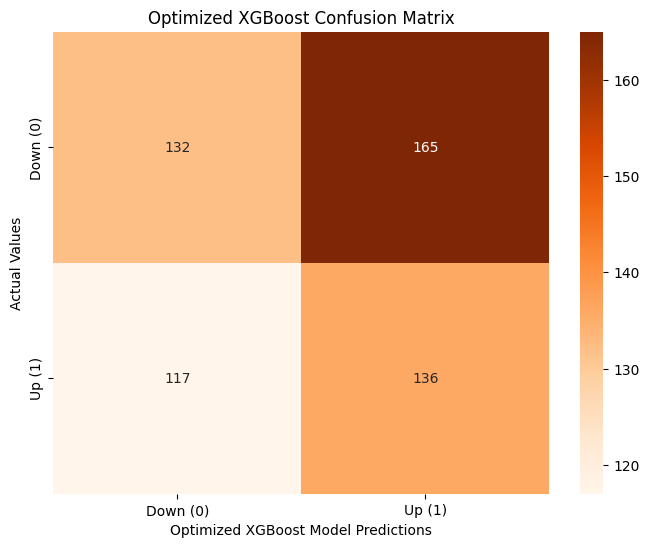


Confusion Matrix:
[[132 165]
 [117 136]]


In [26]:
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel('Optimized XGBoost Model Predictions')
plt.ylabel('Actual Values')
plt.title('Optimized XGBoost Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
print(conf_matrix_tuned)

# --- Saving the Best Model for production ---

In [24]:
model_output_path = "../data/model/"
model_filename_tuned_xgb = "alpha_predictor_model_tuned_xgb.pkl"
os.makedirs(model_output_path, exist_ok=True)
joblib.dump(best_model_xgb, os.path.join(model_output_path, model_filename_tuned_xgb))

print(f"\nOptimized XGBoost model successfully saved to: {os.path.join(model_output_path, model_filename_tuned_xgb)}")


Optimized XGBoost model successfully saved to: ../data/model/alpha_predictor_model_tuned_xgb.pkl
